In [ ]:
%%capture
!pip install git+https://github.com/openai/CLIP.git
!pip install tgt
# !wget "https://archive.org/download/GEHM_meeting_corpus/corpus/20210323/SeparatedSpeakersVideo/20210323-SP07F.mp4"
# !wget "https://archive.org/download/GEHM_meeting_corpus/corpus/20210323/SeparatedSpeakersAudio/20210323-SP07F.flac"
# !wget "https://archive.org/download/GEHM_meeting_corpus/corpus/20210323/OpenPoseKeypoints/20210323.zip"
# !wget "https://archive.org/download/GEHM_meeting_corpus/corpus/20210323/20210323_Praat_long.TextGrid"
# !wget "https://archive.org/download/GEHM_meeting_corpus/corpus/20210323/20210323_Praat_short.TextGrid"
# !unzip "/content/20210323.zip"

In [ ]:
# #display video can using mp4 or mov format

# from IPython.display import Video
# Video("/content/20210323-SP07F.mp4",embed=True)
# display audio can use flac, mp3, wav format
# from IPython.display import Audio
# Audio("/content/20210323-SP07F.flac", embed=True)


In [ ]:

import os
import json

def read_keypoint_folder(folder_path):
    """Reads keypoint data from a folder into a list of dictionaries.

    Args:
        folder_path: The path to the folder containing the keypoint JSON files.

    Returns:
        A list of dictionaries, where each dictionary represents the keypoint data from a JSON file.
        Returns an empty list if the folder is empty or if no JSON files are found.
        Returns None if the folder path is invalid.
    """

    if not os.path.isdir(folder_path):
        print(f"Error: Invalid folder path: {folder_path}")
        return None

    keypoint_data = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".json"):
            filepath = os.path.join(folder_path, filename)
            try:
                with open(filepath, 'r') as f:
                    keypoint_data.append(json.load(f))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON in file {filename}: {e}")
            except Exception as e:
                print(f"An error occurred while reading {filename}: {e}")

    return keypoint_data


In [ ]:
import tgt

def read_textgrid(filepath):
  """Reads a TextGrid file and prints its tiers and intervals.

  Args:
    filepath: The path to the TextGrid file.
  """
  try:
    tg = tgt.read_textgrid(filepath)
    for tier in tg.tiers:
      print(f"Tier name: {tier.name}")

      for interval in tier.intervals:
        print(f"  Start time: {interval.start_time}, End time: {interval.end_time}, Text: {interval.text}")
      break
  except Exception as e:
    print(f"An error occurred while reading the TextGrid file: {e}")


In [ ]:
def save_segments_to_clips(video_path, segments, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width, height = int(cap.get(3)), int(cap.get(4))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    clip_paths = []

    for i, (start, end) in enumerate(segments):
        cap.set(cv2.CAP_PROP_POS_MSEC, start * 1000)
        out_path = os.path.join(output_dir, f"clip_{i:04d}.mp4")
        out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))
        while cap.get(cv2.CAP_PROP_POS_MSEC) < end * 1000:
            ret, frame = cap.read()
            if not ret:
                break
            out.write(frame)
        out.release()
        clip_paths.append(out_path)

    cap.release()
    return clip_paths

In [ ]:
import cv2
from PIL import Image
import numpy as np
import torch
def extract_clip_embedding_from_segment(video_path, start, end, model, preprocess, device, num_frames=6, pooling="mean"):
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int((end - start) * fps)
    frame_indices = [int(start * fps + i * total_frames / num_frames) for i in range(num_frames)]

    embeddings = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        success, frame = cap.read()
        if not success:
            continue
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        image_input = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            emb = model.encode_image(image_input)
            embeddings.append(emb.cpu().numpy())

    cap.release()
    if not embeddings:
        return None

    emb_stack = np.vstack(embeddings)
    if pooling == "mean":
        return np.mean(emb_stack, axis=0)
    elif pooling == "max":
        return np.max(emb_stack, axis=0)
    elif pooling == "none":
        return emb_stack
    else:
        raise ValueError("Invalid pooling method. Use 'mean' or 'max' or 'none'")

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch
import clip
from tqdm import tqdm
def filter_similar_segments(segments, video_path, similarity_threshold=0.92, num_frames=10,prompt):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)


    # 1. extract clip features for all segment
    segment_features = []
    print("Calculate embedding")
    for i, (start, end) in tqdm(enumerate(segments)):
        emb = extract_clip_embedding_from_segment(
            video_path,
            start,
            end,
            model,
            preprocess,
            device,
            num_frames=num_frames,
            pooling="none"
        )
        if emb is not None:
            segment_features.append((i, emb))


    # 2. similarity matrix
    n = len(segment_features)
    similarity_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            feats_i = segment_features[i][1]
            feats_j = segment_features[j][1]

            # for feature after pooling
            if len(feats_i.shape) == 1 and len(feats_j.shape) == 1:
                sim = cosine_similarity(feats_i.reshape(1, -1), feats_j.reshape(1, -1))[0][0]

            # for feature not using pooling
            elif len(feats_i.shape) == 2 and len(feats_j.shape) == 2:
                sim_matrix = cosine_similarity(feats_i, feats_j)
                sim = np.min(sim_matrix) - 0.1 * np.std(sim_matrix)

            else:
                raise ValueError("Mismatch in feature dimensions: check pooling settings")

            similarity_matrix[i][j] = sim
            similarity_matrix[j][i] = sim

    # 3. using clutering to filter out similar segment
    clustering = AgglomerativeClustering(
        n_clusters=None,
        metric='precomputed',
        linkage='average',
        distance_threshold=1-similarity_threshold
    )

    # change similarity matrix into distance matrix
    distance_matrix = 1 - similarity_matrix
    labels = clustering.fit_predict(distance_matrix)

    # chose representative

    text_tokens = clip.tokenize([prompt]).to(device)
    text_embedding = model.encode_text(text_tokens).detach().cpu().numpy()[0]

    cluster_representatives = {}
    for i, label in enumerate(labels):
        if label not in cluster_representatives:
            cluster_indices = np.where(labels == label)[0]

            scores = []
            for idx in cluster_indices:
                visual_score = np.mean(similarity_matrix[idx][cluster_indices])
                pooled_feat = segment_features[idx][1]
                if len(pooled_feat.shape) == 2:
                    pooled_feat = np.mean(pooled_feat, axis=0)


                # add language part
                text_score = cosine_similarity(
                    pooled_feat.reshape(1, -1),
                    text_embedding.reshape(1, -1)
                )[0][0]


                fused_score = 0.7 * visual_score + 0.3 * text_score
                scores.append(fused_score)

            best_idx = cluster_indices[np.argmax(scores)]
            cluster_representatives[label] = segments[segment_features[best_idx][0]]
    #for i, label in enumerate(labels):
     #   if label not in cluster_representatives:
            # select one as representative
      #      cluster_indices = np.where(labels == label)[0]
       #     avg_similarities = np.mean(similarity_matrix[cluster_indices][:, cluster_indices], axis=1)
           # best_idx = cluster_indices[np.argmax(avg_similarities)]
            #cluster_representatives[label] = segments[segment_features[best_idx][0]]

    filtered_segments = list(cluster_representatives.values())

    #sorting in time order
    filtered_segments.sort(key=lambda x: x[0])

    print(f"initial segments: {len(segments)}")
    print(f"filtered segments: {len(filtered_segments)}")

    return filtered_segments


In [ ]:
import cv2
import numpy as np
import math

def estimate_head_orientation(keypoints):
    """
    Estimate head orientation (yaw, pitch, roll) from 2D facial keypoints.

    Parameters:
    - keypoints: OpenPose keypoints dictionary

    Returns:
    - orientation_vector: [yaw, pitch, roll] in degrees
    """
    try:
        pose_keypoints = keypoints['people'][0]['pose_keypoints_2d']
        keypoints_array = np.array(pose_keypoints).reshape(-1, 3)

        # Extract facial keypoints (indices from OpenPose face model)
        nose = keypoints_array[0][:2]  # Nose tip
        left_eye = keypoints_array[15][:2]  # Left eye
        right_eye = keypoints_array[16][:2]  # Right eye

        # Check confidence scores
        confidences = [keypoints_array[i][2] for i in [0, 15, 16]]
        if any(conf <= 0.3 for conf in confidences):  # Increased threshold
            # print(f"Warning: Low confidence keypoints - Nose: {confidences[0]:.2f}, "
                #   f"Left eye: {confidences[1]:.2f}, Right eye: {confidences[2]:.2f}")
            return None

        # Calculate eye center and eye line
        eye_center = (left_eye + right_eye) / 2.0
        eye_line = right_eye - left_eye
        eye_distance = np.linalg.norm(eye_line)

        # Avoid division by zero
        if eye_distance < 1e-6:
            print("Warning: Eyes too close together")
            return None

        # ROLL: Rotation around Z-axis (head tilt)
        # Angle of the line connecting the eyes
        roll = math.degrees(math.atan2(eye_line[1], eye_line[0]))

        # YAW: Rotation around Y-axis (left-right head turn)
        # Based on horizontal offset of nose from eye center
        # Normalize by eye distance to make it scale-invariant
        nose_eye_offset_x = (nose[0] - eye_center[0]) / eye_distance
        # Clamp to reasonable range and scale
        nose_eye_offset_x = np.clip(nose_eye_offset_x, -0.5, 0.5)
        yaw = math.degrees(math.asin(nose_eye_offset_x * 2))  # Scale up the sensitivity

        # PITCH: Rotation around X-axis (up-down head tilt)
        # Based on vertical offset of nose from eye center
        # Normalize by eye distance
        nose_eye_offset_y = (nose[1] - eye_center[1]) / eye_distance
        # Clamp to reasonable range and scale
        nose_eye_offset_y = np.clip(nose_eye_offset_y, -1.0, 1.0)
        pitch = math.degrees(math.atan(nose_eye_offset_y))

        return [yaw, pitch, roll]

    except Exception as e:
        print(f"Error in estimate_head_orientation: {e}")
        return None


def draw_yaw_pitch_roll_vectors(image, orientation_degrees, center_point=None, scale=100):
    """
    Draw 3D orientation vectors on 2D image.

    Parameters:
    - image: Input image
    - orientation_degrees: [yaw, pitch, roll] in degrees
    - center_point: (x, y) center point, defaults to image center
    - scale: Scale factor for vector length

    Returns:
    - Image with orientation vectors drawn
    """
    yaw_deg, pitch_deg, roll_deg = orientation_degrees

    # Convert to radians
    yaw = math.radians(yaw_deg)
    pitch = math.radians(pitch_deg)
    roll = math.radians(roll_deg)

    # Make a copy of the image
    img = image.copy()

    # Get center point
    if center_point is None:
        height, width = img.shape[:2]
        center = (width // 2, height // 2)
    else:
        center = center_point

    # Define 3D unit vectors for X, Y, Z axes
    axes_3d = np.array([
        [1, 0, 0],  # X-axis (red) - points right
        [0, 1, 0],  # Y-axis (green) - points forward (into screen)
        [0, 0, 1],  # Z-axis (blue) - points up
    ], dtype=np.float32)

    # Rotation matrices
    def rotation_matrix_x(angle):
        """Rotation around X-axis (pitch)"""
        cos_a, sin_a = math.cos(angle), math.sin(angle)
        return np.array([
            [1, 0, 0],
            [0, cos_a, -sin_a],
            [0, sin_a, cos_a]
        ])

    def rotation_matrix_y(angle):
        """Rotation around Y-axis (yaw)"""
        cos_a, sin_a = math.cos(angle), math.sin(angle)
        return np.array([
            [cos_a, 0, sin_a],
            [0, 1, 0],
            [-sin_a, 0, cos_a]
        ])

    def rotation_matrix_z(angle):
        """Rotation around Z-axis (roll)"""
        cos_a, sin_a = math.cos(angle), math.sin(angle)
        return np.array([
            [cos_a, -sin_a, 0],
            [sin_a, cos_a, 0],
            [0, 0, 1]
        ])

    # Apply rotations in order: Roll -> Pitch -> Yaw (ZYX convention)
    R = rotation_matrix_y(yaw) @ rotation_matrix_x(pitch) @ rotation_matrix_z(roll)

    # Apply rotation to the axes
    rotated_axes = (R @ axes_3d.T).T

    # Project 3D to 2D (orthographic projection, ignore Z)
    axes_2d = rotated_axes[:, :2] * scale

    # Colors and labels
    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]  # BGR: Red, Green, Blue
    labels = ['X (Right)', 'Y (Forward)', 'Z (Up)']

    # Draw the axes
    for i, (axis_2d, color, label) in enumerate(zip(axes_2d, colors, labels)):
        end_point = (
            int(center[0] + axis_2d[0]),
            int(center[1] - axis_2d[1])  # Flip Y for image coordinates
        )

        # Draw arrow
        cv2.arrowedLine(img, center, end_point, color, 3, tipLength=0.2)

        # Add label
        label_pos = (end_point[0] + 10, end_point[1])
        cv2.putText(img, label, label_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Draw center point
    cv2.circle(img, center, 5, (255, 255, 255), -1)

    # Add angle information with better formatting
    angle_texts = [
        f"Yaw: {yaw_deg:+.1f}° (L/R turn)",
        f"Pitch: {pitch_deg:+.1f}° (Up/Down)",
        f"Roll: {roll_deg:+.1f}° (Tilt)"
    ]

    # Draw background for text
    for i, text in enumerate(angle_texts):
        y_pos = 30 + i * 30
        (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        cv2.rectangle(img, (5, y_pos - 25), (15 + text_width, y_pos + 5), (0, 0, 0), -1)
        cv2.putText(img, text, (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    return img


def draw_keypoints(image, keypoints, scale_factor=2.25):
    """
    Draw keypoints on image with improved visualization.

    Parameters:
    - image: Input image
    - keypoints: OpenPose keypoints dictionary
    - scale_factor: Factor to scale down keypoint coordinates

    Returns:
    - Image with keypoints drawn
    """
    img = image.copy()

    try:
        pose_keypoints = keypoints['people'][0]['pose_keypoints_2d']
        keypoints_array = np.array(pose_keypoints).reshape(-1, 3)

        # Important facial keypoints for head pose estimation
        important_indices = [0, 15, 16]  # nose, left_eye, right_eye

        for i, (x, y, confidence) in enumerate(keypoints_array):
            if confidence > 0.2:
                scaled_x = int(x / scale_factor)
                scaled_y = int(y / scale_factor)

                # Use different colors for important keypoints
                if i in important_indices:
                    color = (0, 255, 0)  # Green for important points
                    radius = 8
                else:
                    color = (255, 0, 0)  # Blue for other points
                    radius = 5

                cv2.circle(img, (scaled_x, scaled_y), radius, color, -1)

                # Add index label for important keypoints
                if i in important_indices:
                    label = ['Nose', 'L_Eye', 'R_Eye'][important_indices.index(i)]
                    cv2.putText(img, f"{label}({i})", (scaled_x + 10, scaled_y),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    except Exception as e:
        print(f"Error in draw_keypoints: {e}")

    return img


def get_average_head_orientation(segment, fps, keypoint_list, log=False):
    """
    Calculate average head orientation over a time segment from a list of keypoints.

    Parameters:
    - segment: [start_time, end_time] in seconds
    - fps: frames per second of the video
    - keypoint_list: list of keypoint dictionaries for each frame

    Returns:
    - average_orientation: [avg_yaw, avg_pitch, avg_roll] in degrees
    - valid_frames: number of frames with valid orientation data
    - orientation_std: [std_yaw, std_pitch, std_roll] standard deviation
    """
    start_time, end_time = segment

    # Convert time segment to frame indices
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)

    # Ensure frame indices are within bounds
    start_frame = max(0, start_frame)
    end_frame = min(len(keypoint_list) - 1, end_frame)

    if start_frame >= end_frame:
        print(f"Warning: Invalid segment [{start_time}, {end_time}] seconds")
        return None, 0, None

    valid_orientations = []
    failed_frames = 0

    # Process each frame in the segment
    for frame_idx in range(start_frame, end_frame + 1):
        if frame_idx < len(keypoint_list):
            keypoints = keypoint_list[frame_idx]

            # Skip if no people detected in frame
            if not keypoints.get('people') or len(keypoints['people']) == 0:
                failed_frames += 1
                continue

            # Estimate head orientation for this frame
            orientation = estimate_head_orientation(keypoints)

            if orientation is not None:
                valid_orientations.append(orientation)
            else:
                failed_frames += 1

    # Check if we have enough valid data
    valid_frames = len(valid_orientations)

    if valid_frames == 0:
        print(f"Warning: No valid head orientations found in segment [{start_time}, {end_time}]")
        return None, 0, None

    if valid_frames < 3:
        print(f"Warning: Only {valid_frames} valid frames found in segment")

    # Convert to numpy array for easier computation
    orientations_array = np.array(valid_orientations)

    # Handle angle wraparound for roll (can wrap around ±180°)
    # Use circular mean for roll calculation
    roll_radians = np.radians(orientations_array[:, 2])
    roll_sin_mean = np.mean(np.sin(roll_radians))
    roll_cos_mean = np.mean(np.cos(roll_radians))
    avg_roll = np.degrees(np.arctan2(roll_sin_mean, roll_cos_mean))

    # For yaw and pitch, use regular mean (assuming they don't wrap around in typical usage)
    avg_yaw = np.mean(orientations_array[:, 0])
    avg_pitch = np.mean(orientations_array[:, 1])

    average_orientation = [avg_yaw, avg_pitch, avg_roll]

    # Calculate standard deviations
    # For roll, use circular standard deviation
    roll_var = 1 - (roll_sin_mean**2 + roll_cos_mean**2)
    roll_std = np.degrees(np.sqrt(-2 * np.log(np.sqrt(roll_sin_mean**2 + roll_cos_mean**2))))

    # For yaw and pitch, use regular standard deviation
    yaw_std = np.std(orientations_array[:, 0])
    pitch_std = np.std(orientations_array[:, 1])

    orientation_std = [yaw_std, pitch_std, roll_std]

    # Print summary statistics
    if log:
        print(f"Segment [{start_time:.1f}s, {end_time:.1f}s]: "
            f"Valid frames: {valid_frames}/{end_frame - start_frame + 1}")
        print(f"Average orientation - Yaw: {avg_yaw:.1f}° (±{yaw_std:.1f}°), "
            f"Pitch: {avg_pitch:.1f}° (±{pitch_std:.1f}°), "
            f"Roll: {avg_roll:.1f}° (±{roll_std:.1f}°)")

    return average_orientation, valid_frames, orientation_std


def get_head_orientation_statistics(segment, fps, keypoint_list):
    """
    Get detailed statistics about head orientation over a time segment.

    Parameters:
    - segment: [start_time, end_time] in seconds
    - fps: frames per second of the video
    - keypoint_list: list of keypoint dictionaries for each frame

    Returns:
    - stats: dictionary with detailed statistics
    """
    start_time, end_time = segment
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)

    # Ensure frame indices are within bounds
    start_frame = max(0, start_frame)
    end_frame = min(len(keypoint_list) - 1, end_frame)

    if start_frame >= end_frame:
        return None

    valid_orientations = []
    frame_timestamps = []

    # Collect all valid orientations with timestamps
    for frame_idx in range(start_frame, end_frame + 1):
        if frame_idx < len(keypoint_list):
            keypoints = keypoint_list[frame_idx]

            if keypoints.get('people') and len(keypoints['people']) > 0:
                orientation = estimate_head_orientation(keypoints)

                if orientation is not None:
                    valid_orientations.append(orientation)
                    frame_timestamps.append(frame_idx / fps)

    if len(valid_orientations) == 0:
        return None

    orientations_array = np.array(valid_orientations)

    # Calculate comprehensive statistics
    stats = {
        'segment': segment,
        'total_frames': end_frame - start_frame + 1,
        'valid_frames': len(valid_orientations),
        'success_rate': len(valid_orientations) / (end_frame - start_frame + 1),
        'timestamps': frame_timestamps,
        'all_orientations': valid_orientations,

        # Mean values
        'mean_yaw': np.mean(orientations_array[:, 0]),
        'mean_pitch': np.mean(orientations_array[:, 1]),
        'mean_roll': np.mean(orientations_array[:, 2]),

        # Standard deviations
        'std_yaw': np.std(orientations_array[:, 0]),
        'std_pitch': np.std(orientations_array[:, 1]),
        'std_roll': np.std(orientations_array[:, 2]),

        # Min/Max values
        'min_yaw': np.min(orientations_array[:, 0]),
        'max_yaw': np.max(orientations_array[:, 0]),
        'min_pitch': np.min(orientations_array[:, 1]),
        'max_pitch': np.max(orientations_array[:, 1]),
        'min_roll': np.min(orientations_array[:, 2]),
        'max_roll': np.max(orientations_array[:, 2]),

        # Range values
        'range_yaw': np.ptp(orientations_array[:, 0]),
        'range_pitch': np.ptp(orientations_array[:, 1]),
        'range_roll': np.ptp(orientations_array[:, 2]),

        # Median values
        'median_yaw': np.median(orientations_array[:, 0]),
        'median_pitch': np.median(orientations_array[:, 1]),
        'median_roll': np.median(orientations_array[:, 2]),
    }

    return stats


def analyze_head_movement_patterns(segment, fps, keypoint_list, window_size=1.0):
    """
    Analyze head movement patterns over time within a segment.

    Parameters:
    - segment: [start_time, end_time] in seconds
    - fps: frames per second of the video
    - keypoint_list: list of keypoint dictionaries for each frame
    - window_size: size of sliding window in seconds for movement analysis

    Returns:
    - movement_analysis: dictionary with movement patterns and statistics
    """
    start_time, end_time = segment
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)

    # Collect orientations with frame indices
    frame_orientations = {}
    for frame_idx in range(start_frame, end_frame + 1):
        if frame_idx < len(keypoint_list):
            keypoints = keypoint_list[frame_idx]

            if keypoints.get('people') and len(keypoints['people']) > 0:
                orientation = estimate_head_orientation(keypoints)
                if orientation is not None:
                    frame_orientations[frame_idx] = orientation

    if len(frame_orientations) < 2:
        return None

    # Calculate frame-to-frame differences
    sorted_frames = sorted(frame_orientations.keys())
    angular_velocities = []
    time_diffs = []

    for i in range(1, len(sorted_frames)):
        prev_frame = sorted_frames[i-1]
        curr_frame = sorted_frames[i]

        prev_orientation = frame_orientations[prev_frame]
        curr_orientation = frame_orientations[curr_frame]

        # Calculate angular differences
        diff_yaw = curr_orientation[0] - prev_orientation[0]
        diff_pitch = curr_orientation[1] - prev_orientation[1]
        diff_roll = curr_orientation[2] - prev_orientation[2]

        # Time difference
        time_diff = (curr_frame - prev_frame) / fps

        # Angular velocities (degrees per second)
        if time_diff > 0:
            vel_yaw = diff_yaw / time_diff
            vel_pitch = diff_pitch / time_diff
            vel_roll = diff_roll / time_diff

            angular_velocities.append([vel_yaw, vel_pitch, vel_roll])
            time_diffs.append(time_diff)

    if len(angular_velocities) == 0:
        return None

    velocities_array = np.array(angular_velocities)

    # Calculate movement statistics
    movement_analysis = {
        'segment': segment,
        'num_valid_transitions': len(angular_velocities),
        'avg_time_between_detections': np.mean(time_diffs),

        # Average angular velocities
        'avg_yaw_velocity': np.mean(np.abs(velocities_array[:, 0])),
        'avg_pitch_velocity': np.mean(np.abs(velocities_array[:, 1])),
        'avg_roll_velocity': np.mean(np.abs(velocities_array[:, 2])),

        # Maximum angular velocities
        'max_yaw_velocity': np.max(np.abs(velocities_array[:, 0])),
        'max_pitch_velocity': np.max(np.abs(velocities_array[:, 1])),
        'max_roll_velocity': np.max(np.abs(velocities_array[:, 2])),

        # Total movement
        'total_yaw_movement': np.sum(np.abs(velocities_array[:, 0]) * np.array(time_diffs)),
        'total_pitch_movement': np.sum(np.abs(velocities_array[:, 1]) * np.array(time_diffs)),
        'total_roll_movement': np.sum(np.abs(velocities_array[:, 2]) * np.array(time_diffs)),

        # Movement variability
        'yaw_velocity_std': np.std(velocities_array[:, 0]),
        'pitch_velocity_std': np.std(velocities_array[:, 1]),
        'roll_velocity_std': np.std(velocities_array[:, 2]),
    }

    # Classify movement intensity
    total_movement = (movement_analysis['total_yaw_movement'] +
                     movement_analysis['total_pitch_movement'] +
                     movement_analysis['total_roll_movement'])

    duration = end_time - start_time
    movement_intensity = total_movement / duration

    if movement_intensity < 10:
        movement_classification = "Static"
    elif movement_intensity < 30:
        movement_classification = "Low movement"
    elif movement_intensity < 60:
        movement_classification = "Moderate movement"
    else:
        movement_classification = "High movement"

    movement_analysis['movement_intensity'] = movement_intensity
    movement_analysis['movement_classification'] = movement_classification

    return movement_analysis


def process_frame_with_head_pose(image, openpose_keypoints):
    """
    Complete pipeline to process a frame with head pose estimation.

    Parameters:
    - image: Input image
    - openpose_keypoints: OpenPose detection results

    Returns:
    - processed_image: Image with keypoints and head pose visualization
    - head_orientation: [yaw, pitch, roll] in degrees or None if failed
    """
    # Draw keypoints
    img_with_keypoints = draw_keypoints(image, openpose_keypoints)

    # Estimate head orientation
    head_orientation = estimate_head_orientation(openpose_keypoints)

    if head_orientation is not None:
        # Draw orientation vectors
        final_image = draw_yaw_pitch_roll_vectors(img_with_keypoints, head_orientation)
        print(f"Head orientation - Yaw: {head_orientation[0]:.1f}°, "
              f"Pitch: {head_orientation[1]:.1f}°, Roll: {head_orientation[2]:.1f}°")
        return final_image, head_orientation
    else:
        print("Could not estimate head orientation")
        return img_with_keypoints, None
def most_close_head_orientation(segments, head_orientation, reference, num=50):
    """Finds the most similar head orientation to refence.
    Args:
        segments: The list of segment of the video.
        head_orientation: The head orientation data.
        reference: The reference head orientation.
    Returns:
        The most similar head orientation to the reference.
    """
    head_orientation = np.array(head_orientation)
    reference = np.array(reference)
    distances = np.linalg.norm(head_orientation - reference, axis=1)
    num = min(num, len(segments))
    closest_indices = np.argsort(distances)[:num]
    closest_segments = [segments[i] for i in closest_indices]
    closest_head_orientation = head_orientation[closest_indices]
    return closest_segments, closest_head_orientation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def visualize_frame(video_id, person_id, frame_idx):
    video_path = f"/content/data/{video_id}-{person_id}.mp4"
    keypoints_path = f"/content/data/{video_id}/{video_id}-{person_id}_keypoints"

    #segment the video
    cap = cv2.VideoCapture(video_path)
    keypoints = read_keypoint_folder(keypoints_path)

    if not cap.isOpened():
        print("Error opening video file.")
    else:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx-1)
        video_resolution = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
        print(f"Video resolution: {video_resolution}")


        ret, frame = cap.read()

        if ret:
            # Convert the frame to RGB
            frame_sample = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        else:
            print("Error reading frame.")

        cap.release()
    frame_sample, orientation = process_frame_with_head_pose(frame_sample, keypoints[frame_idx])
    print("\nOpenPose Example:")
    print(orientation)
    plt.imshow(frame_sample)
    plt.show()

In [ ]:
%%time
import cv2
import json
import os
import tgt

def is_talking(segment, textgrid, tier_name=""):
    for tier in textgrid.tiers:
        if tier.name == tier_name:
            for interval in tier.intervals:
                if (segment[0] < interval.end_time and segment[1] > interval.start_time):
                    return True
    return False


def is_visible(segment, fps, keypoints_list, thresthold=0.95):
    start_frame = int(segment[0] * fps)
    end_frame = int(segment[1] * fps)
    visible_count = 0
    for frame in range(start_frame, end_frame):
        if keypoints_list[frame]['people']:
            visible_count += 1
    return visible_count / (end_frame - start_frame) >= thresthold

def process_video(video_id, person_id, duration, overlap, number_segment=20, num_frames=10, similarity_threshold=0.92,prompt=None):
    """
    Segments a video based on given parameters and applies various filters.

    Args:
        video_path: Path to the video file.
        person_id: ID of the person to focus on (not fully implemented in this example).
        duration: Duration of each segment in seconds.
        overlap: Overlap between consecutive segments in seconds.

    Returns:
        A list of filtered video segments (currently returns an empty list).
        This function is a placeholder and needs further development to implement all the filtering steps.

    """
    video_path = f"/content/data/{video_id}-{person_id}.mp4"
    keypoints_path = f"/content/data/{video_id}/{video_id}-{person_id}_keypoints"
    textgrid_path = f"/content/data/{video_id}_Praat_long.TextGrid"
    # audio_path = f"/content/{video_id}-{person_id}.flac"

    gender_dict = {
        "SP01F": "woman",
        "SP02F": "woman",
        "SP03M": "man",
        "SP04F": "woman",
        "SP05F": "woman",
        "SP06M": "man",
        "SP07F": "woman",
        "SP08M": "man",
        "SP09M": "man",
        "SP10F": "woman"
    }

    def get_prompt_by_person(person_id):
        gender = gender_dict.get(person_id, "person")
        return f"a {gender} is sitting in front of a computer having an online meeting"

    if prompt is None:
        prompt = get_prompt_by_person(person_id)

    #segment the video
    cap = cv2.VideoCapture(video_path)
    textgrid = tgt.io.read_textgrid(textgrid_path)
    keypoints = read_keypoint_folder(keypoints_path)


    video_resolution = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    print(f"Video resolution: {video_resolution}")
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    segment_count = 0
    segments = []
    start_time = 0
    while start_time < total_frames / fps:
        end_time = start_time + duration
        if end_time > total_frames / fps:
            end_time = total_frames / fps
        segments.append((start_time, end_time))
        start_time += duration - overlap
        segment_count += 1
    cap.release()
    print(f"Total segments: {segment_count}")

    print("filter video that most people are actively speaking")
    segments = [segment for segment in segments if not is_talking(segment, textgrid, person_id)]
    print(f"Video segments left: {len(segments)}")

    print("filter video that people is detected in 90% of frame")
    segments = [segment for segment in segments if is_visible(segment, fps, keypoints)]
    print(f"Video segments left: {len(segments)}")


    # 3. filtering visually similar segment
    print(f"start to filter visually similar segment...")
    segments = filter_similar_segments(
        segments,
        video_path,
        similarity_threshold=similarity_threshold,
        num_frames=num_frames,
        prompt
    )
    print(f"Video segments left: {len(segments)}")

    average_head_orientations  = np.array([get_average_head_orientation(segment,fps, keypoints)[0] for segment in segments])
    print("only keep filter that have the head orientation close to")
    segments, average_head_orientations = most_close_head_orientation(segments, average_head_orientations,[0,0,0], number_segment)
    print(f"Video segments left: {len(segments)}")

    output_dir = f"/content/filtered_clips/{video_id}-{person_id}"
    clip_paths = save_segments_to_clips(video_path, segments, output_dir)
    return segments

    # return filtered_segments



video_id = "20210323"
person_id = 'SP07F'
segment_duration = 5  # 5 seconds
overlap_duration = 1 # 1 second
num_frames=10
similarity_threshold=0.92
number_segment = 10
filtered_video_segments = process_video(video_id, person_id, segment_duration, overlap_duration, number_segment, num_frames, similarity_threshold,prompt)
# filtered_video_segments




Video resolution: (854, 480)
Total segments: 326
filter video that most people are actively speaking
Video segments left: 296
filter video that people is detected in 90% of frame
Video segments left: 294
start to filter visually similar segment...


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 189MiB/s]


Calculate embedding


7it [00:36,  5.25s/it]


KeyboardInterrupt: 

Video resolution: (854, 480)
Head orientation - Yaw: 16.9°, Pitch: 28.3°, Roll: -2.5°

OpenPose Example:
[16.864625435109836, 28.263957126578184, -2.456429381769581]


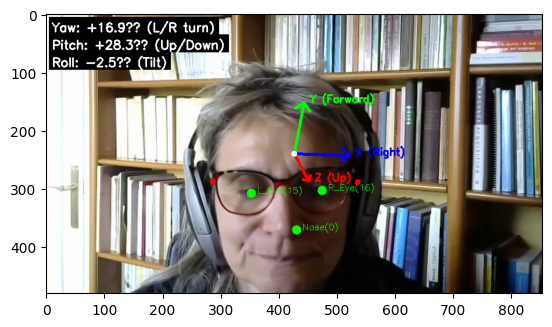

Video resolution: (854, 480)
Head orientation - Yaw: 12.6°, Pitch: 35.7°, Roll: -9.5°

OpenPose Example:
[12.620456304597756, 35.67223581469907, -9.469445685576266]


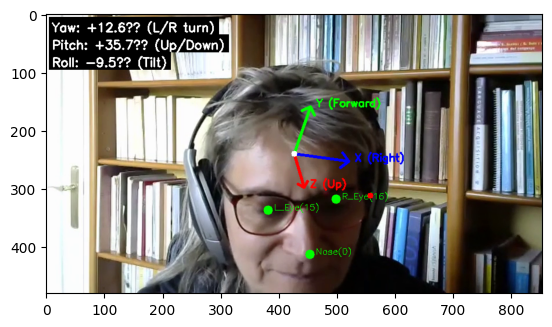

Video resolution: (854, 480)
Head orientation - Yaw: 5.9°, Pitch: 31.0°, Roll: -1.9°

OpenPose Example:
[5.850105814565233, 30.990342194213234, -1.9059123676405245]


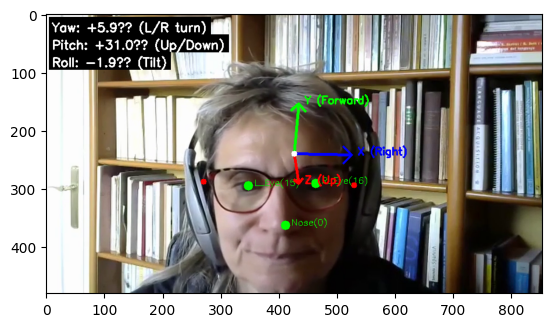

Video resolution: (854, 480)
Head orientation - Yaw: 16.8°, Pitch: 30.7°, Roll: -1.9°

OpenPose Example:
[16.760091003448828, 30.72155949345873, -1.889149735983445]


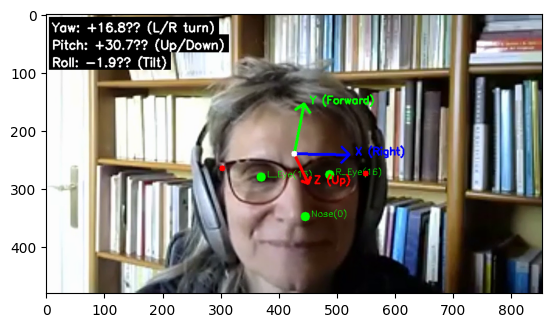

Video resolution: (854, 480)
Head orientation - Yaw: -2.0°, Pitch: 32.3°, Roll: -5.4°

OpenPose Example:
[-2.021358477867539, 32.2902344250927, -5.395699473629054]


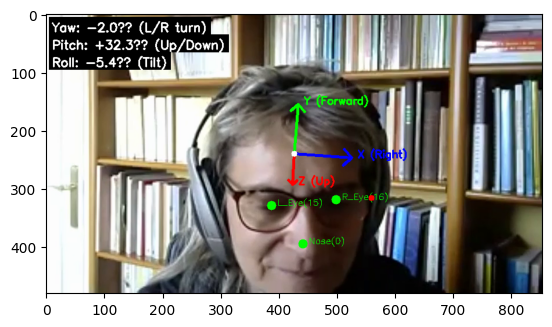

Video resolution: (854, 480)
Head orientation - Yaw: 21.2°, Pitch: 30.2°, Roll: -4.5°

OpenPose Example:
[21.2444623599851, 30.243929900087117, -4.5199823709647475]


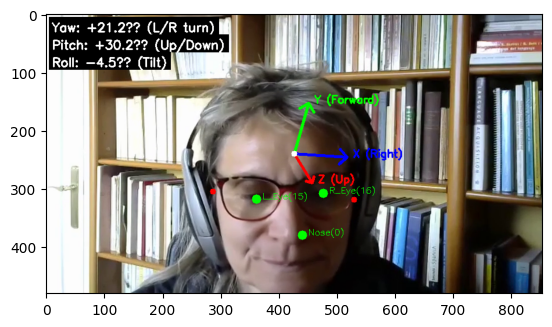

Video resolution: (854, 480)
Head orientation - Yaw: 8.0°, Pitch: 33.9°, Roll: -4.0°

OpenPose Example:
[7.967652749858869, 33.93313234597734, -4.000209383229085]


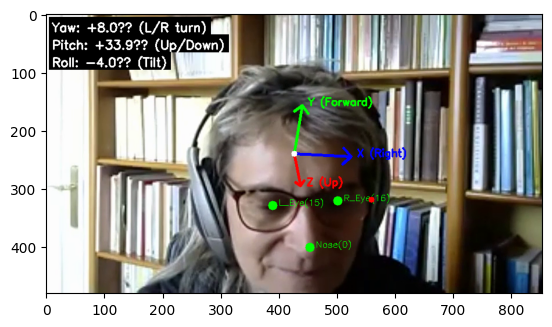

Video resolution: (854, 480)
Could not estimate head orientation

OpenPose Example:
None


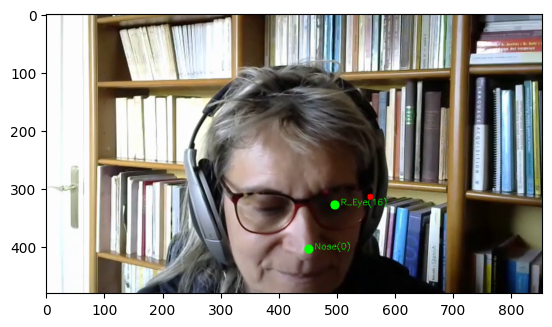

Video resolution: (854, 480)
Error in draw_keypoints: list index out of range
Error in estimate_head_orientation: list index out of range
Could not estimate head orientation

OpenPose Example:
None


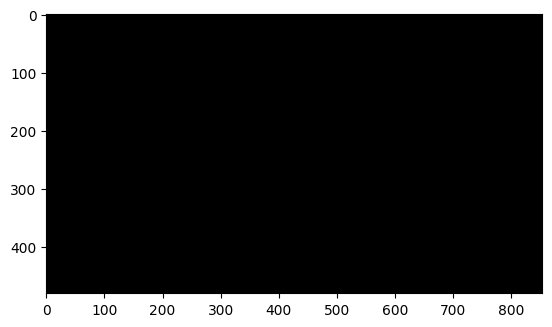

Video resolution: (854, 480)
Head orientation - Yaw: 26.6°, Pitch: 34.1°, Roll: -3.9°

OpenPose Example:
[26.55574955280576, 34.089482733003976, -3.939340886438715]


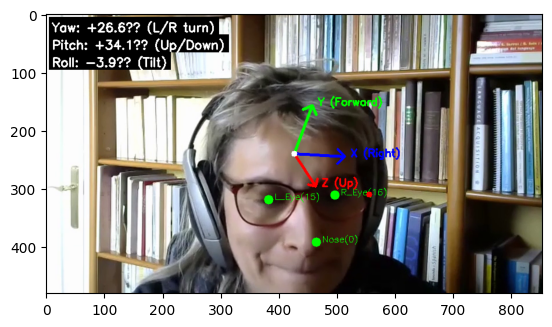

Video resolution: (854, 480)
Could not estimate head orientation

OpenPose Example:
None


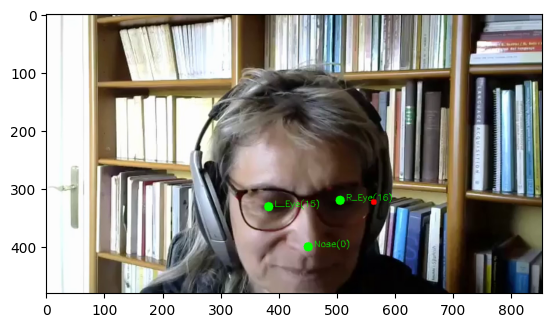

Video resolution: (854, 480)
Head orientation - Yaw: 11.8°, Pitch: 29.4°, Roll: -2.0°

OpenPose Example:
[11.760911841817377, 29.359121072409383, -1.9501460265961823]


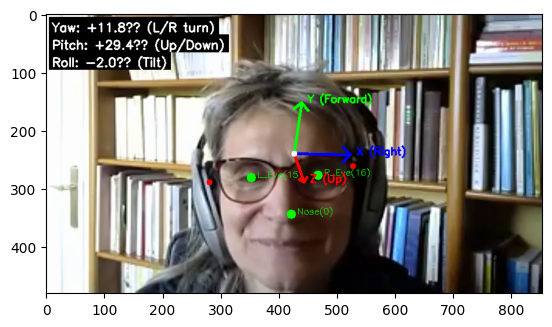

Video resolution: (854, 480)
Head orientation - Yaw: 14.5°, Pitch: 29.1°, Roll: -1.3°

OpenPose Example:
[14.484824365534779, 29.09643353428354, -1.3023294964256276]


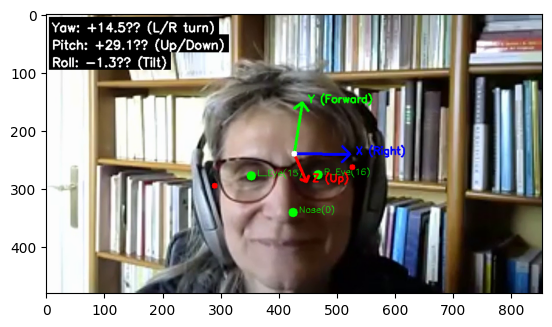

Video resolution: (854, 480)
Could not estimate head orientation

OpenPose Example:
None


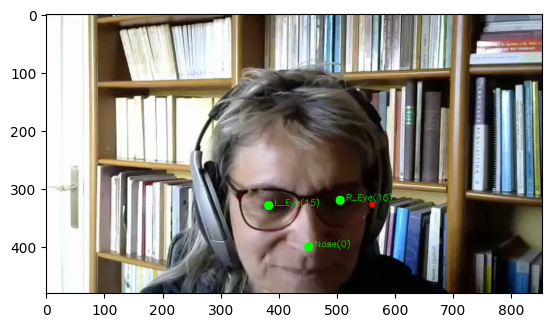

In [ ]:
for segment in filtered_video_segments:
    start, end = segment
    idx = (start+end)//2
    visualize_frame(video_id, person_id, idx)

In [ ]:
# !mkdir data
%cd data
!pwd

/content/data
/content/data


In [ ]:
import os
meeting_to_participants = {'20210323': ['SP01F', 'SP03M', 'SP07F', 'SP06M'],
 '20210504': ['SP01F', 'SP04F', 'SP08M', 'SP09M'],
 '20210616': ['SP01F', 'SP02F', 'SP05F', 'SP06M', 'SP03M', 'SP04F'],
 '20211007': ['SP01F', 'SP05F', 'SP07F', 'SP04F', 'SP03M'],
 '20211119': ['SP01F', 'SP05F', 'SP04F', 'SP03M', 'SP02F', 'SP07F'],
 '20220204': ['SP03M', 'SP01F', 'SP05F', 'SP04F', 'SP07F', 'SP02F'],
 '20220408': ['SP05F','SP01F','SP02F','SP03M','SP04F','SP06M','SP07F','SP09M'],
 '20220610': ['SP02F', 'SP01F', 'SP03M', 'SP07F', 'SP04F'],
 '20220722': ['SP02F', 'SP01F', 'SP07F', 'SP05F', 'SP04F'],
 '20220916': ['SP05F', 'SP01F', 'SP03M', 'SP04F', 'SP07F'],
 '20221209': ['SP05F','SP01F','SP07F','SP03M','SP06M','SP02F','SP04F','SP09M'],
 '20230310': ['SP04F', 'SP01F', 'SP05F', 'SP02F', 'SP07F', 'SP03M', 'SP06M']
}

# prompt_to_video = {'20210323':['prompt1'],['prompt2'],['prompt3'],['prompt4']}

segment_duration = 5  # 5 seconds
overlap_duration = 2 # 2 second
num_frames=10
similarity_threshold=0.92
number_segment = 10

#download data
for meeting in meeting_to_participants:
    print(f"{meeting}: {len(meeting_to_participants[meeting])}")
    if os.path.exists(f"{meeting}"):
        !rm -rf "{meeting}"
        !wget "https://archive.org/download/GEHM_meeting_corpus/corpus/{meeting}/OpenPoseKeypoints/{meeting}.zip"
        # !unzip -o -q -P 123456 "{meeting}.zip"
        # !rm -rf "{meeting}.zip"
    # if not os.path.exists(f"{meeting}_Praat_long.TextGrid"):
    #     !wget "https://archive.org/download/GEHM_meeting_corpus/corpus/{meeting}/20210323_Praat_long.TextGrid"
    # for participant in meeting_to_participants[meeting]:
    #     if not os.path.exists(f"{meeting}-{participant}.mp4"):
    #         !wget "https://archive.org/download/GEHM_meeting_corpus/corpus/{meeting}/SeparatedSpeakersVideo/{meeting}-{participant}.mp4"
        # filtered_video_segments = process_video(meeting, participant, segment_duration, overlap_duration, number_segment, num_frames, similarity_threshold)



20210323: 4
--2025-05-19 08:56:04--  https://archive.org/download/GEHM_meeting_corpus/corpus/20210323/OpenPoseKeypoints/20210323.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dn721604.ca.archive.org/0/items/GEHM_meeting_corpus/corpus/20210323/OpenPoseKeypoints/20210323.zip [following]
--2025-05-19 08:56:04--  https://dn721604.ca.archive.org/0/items/GEHM_meeting_corpus/corpus/20210323/OpenPoseKeypoints/20210323.zip
Resolving dn721604.ca.archive.org (dn721604.ca.archive.org)... 204.62.247.23
Connecting to dn721604.ca.archive.org (dn721604.ca.archive.org)|204.62.247.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109732958 (105M) [application/zip]
Saving to: ‘20210323.zip’

20210323.zip        100%[===================>] 104.65M  54.6MB/s    in 1.9s    

2025-05-19 08:56:07 (54.6 MB/s) - ‘20210323.zip’ saved [10

In [ ]:
meeting_to_participants = {'20210323': ['SP01F', 'SP03M', 'SP07F', 'SP06M'],
 '20210504': ['SP01F', 'SP04F', 'SP08M', 'SP09M'],
 '20210616': ['SP01F', 'SP02F', 'SP05F', 'SP06M', 'SP03M', 'SP04F'],
 '20211007': ['SP01F', 'SP05F', 'SP07F', 'SP04F', 'SP03M'],
 '20211119': ['SP01F', 'SP05F', 'SP04F', 'SP03M', 'SP02F', 'SP07F'],
 '20220204': ['SP03M', 'SP01F', 'SP05F', 'SP04F', 'SP07F', 'SP02F'],
 '20220408': ['SP05F','SP01F','SP02F','SP03M','SP04F','SP06M','SP07F','SP09M'],
 '20220610': ['SP02F', 'SP01F', 'SP03M', 'SP07F', 'SP04F'],
 '20220722': ['SP02F', 'SP01F', 'SP07F', 'SP05F', 'SP04F'],
 '20220916': ['SP05F', 'SP01F', 'SP03M', 'SP04F', 'SP07F'],
 '20221209': ['SP05F','SP01F','SP07F','SP03M','SP06M','SP02F','SP04F','SP09M'],
 '20230310': ['SP04F', 'SP01F', 'SP05F', 'SP02F', 'SP07F', 'SP03M', 'SP06M']
}
#download data
for meeting in meeting_to_participants:
    for participant in meeting_to_participants[meeting]:
        filtered_video_segments = process_video(meeting, participant, segment_duration, overlap_duration, number_segment, num_frames, similarity_threshold,prompt)



NameError: name 'process_video' is not defined

In [ ]:
!zip -r data.zip data

  adding: data/ (stored 0%)
  adding: data/20211119-SP05F.mp4 (deflated 0%)
  adding: data/20220916-SP05F.mp4 (deflated 1%)
  adding: data/20220610-SP07F.mp4 (deflated 1%)
  adding: data/20220916-SP01F.mp4 (deflated 1%)
  adding: data/20221209.zip (stored 0%)
  adding: data/20220916-SP04F.mp4 (deflated 1%)
  adding: data/20211119-SP07F.mp4 (deflated 0%)
  adding: data/20220722-SP07F.mp4 (deflated 1%)
  adding: data/20230310-SP05F.mp4 (deflated 3%)
  adding: data/20220408-SP01F.mp4 (deflated 5%)
  adding: data/20210616-SP04F.mp4 (deflated 1%)
  adding: data/20210616-SP01F.mp4 (deflated 1%)
  adding: data/20220204-SP02F.mp4 (deflated 1%)
  adding: data/20220204-SP05F.mp4 (deflated 1%)
  adding: data/20210323-SP06M.mp4 (deflated 0%)
  adding: data/20211007-SP03M.mp4 (deflated 1%)
  adding: data/20220916-SP07F.mp4 (deflated 1%)
  adding: data/20211119-SP04F.mp4 (deflated 1%)
  adding: data/20230310-SP01F.mp4 (deflated 2%)
  adding: data/20221209-SP01F.mp4 (deflated 1%)
  adding: data/20210

In [ ]:
%cd ..

/content
